In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:" + str(width) + "% !important; }</style>"))
    
fix_layout()

In [2]:
import os
import uuid
import shutil
from glob import glob
from datetime import date

import skimage
from functools import reduce
from skimage import io
import matplotlib.pyplot as plt
import pickle
import numpy as np

%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, trange
import sacred
from sacred.stflow import LogFileWriter

In [3]:
from som_vae import somvae_model
from som_vae.utils import *

In [4]:
from importlib import reload

In [5]:
ex = sacred.Experiment("how", interactive=True) # set interactive to true if you run this in a jupyter notebook
ex.observers.append(sacred.observers.FileStorageObserver.create("./sacred_runs"))
ex.captured_out_filter = sacred.utils.apply_backspaces_and_linefeeds

In [6]:
@ex.config
def ex_config():
    """Sacred configuration for the experiment.
    
    Params:
        num_epochs (int): Number of training epochs.
        patience (int): Patience for the early stopping.
        batch_size (int): Batch size for the training.
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the self-organizing map.
        learning_rate (float): Learning rate for the optimization.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        decay_factor (float): Factor for the learning rate decay.
        name (string): Name of the experiment.
        ex_name (string): Unique name of this particular run.
        logdir (path): Directory for the experiment logs.
        modelpath (path): Path for the model checkpoints.
        interactive (bool): Indicator if there should be an interactive progress bar for the training.
        data_set (string): Data set for the training.
        save_model (bool): Indicator if the model checkpoints should be kept after training and evaluation.
        time_series (bool): Indicator if the model should be trained on linearly interpolated
            MNIST time series.
        mnist (bool): Indicator if the model is trained on MNIST-like data.
    """
    num_epochs = 1
    patience = 100
    batch_size = 32
    latent_dim = 64
    som_dim = [8,8]
    learning_rate = 0.0005
    alpha = 1.0
    beta = 0.9
    gamma = 1.8
    tau = 1.4
    decay_factor = 0.9
    name = ex.get_experiment_info()["name"]
    ex_name = "{}_{}_{}-{}_{}_{}".format(name, latent_dim, som_dim[0], som_dim[1], str(date.today()), uuid.uuid4().hex[:5])
    logdir = "./logs/{}".format(ex_name)
    modelpath = "./models/{}/{}.ckpt".format(ex_name, ex_name)
    interactive = True
    data_set = "fly_data"
    save_model = False
    time_series = False 
    mnist = False 

0.0% of the data for leg 0 is 0
0.0% of the data for leg 1 is 0
0.0% of the data for leg 2 is 0


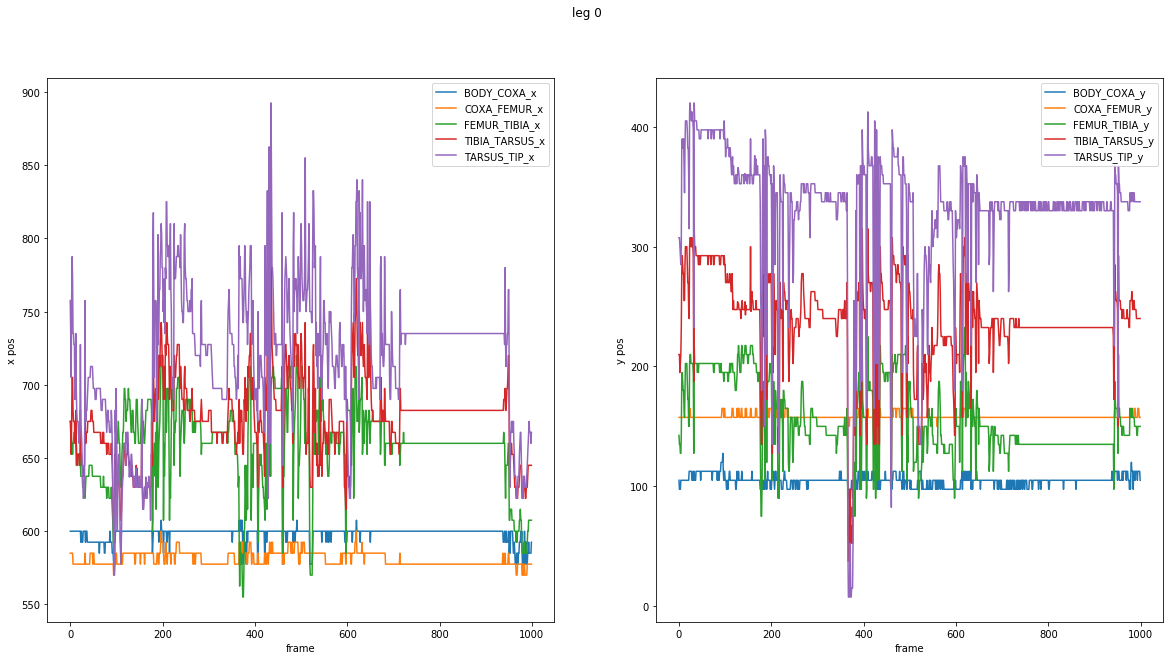

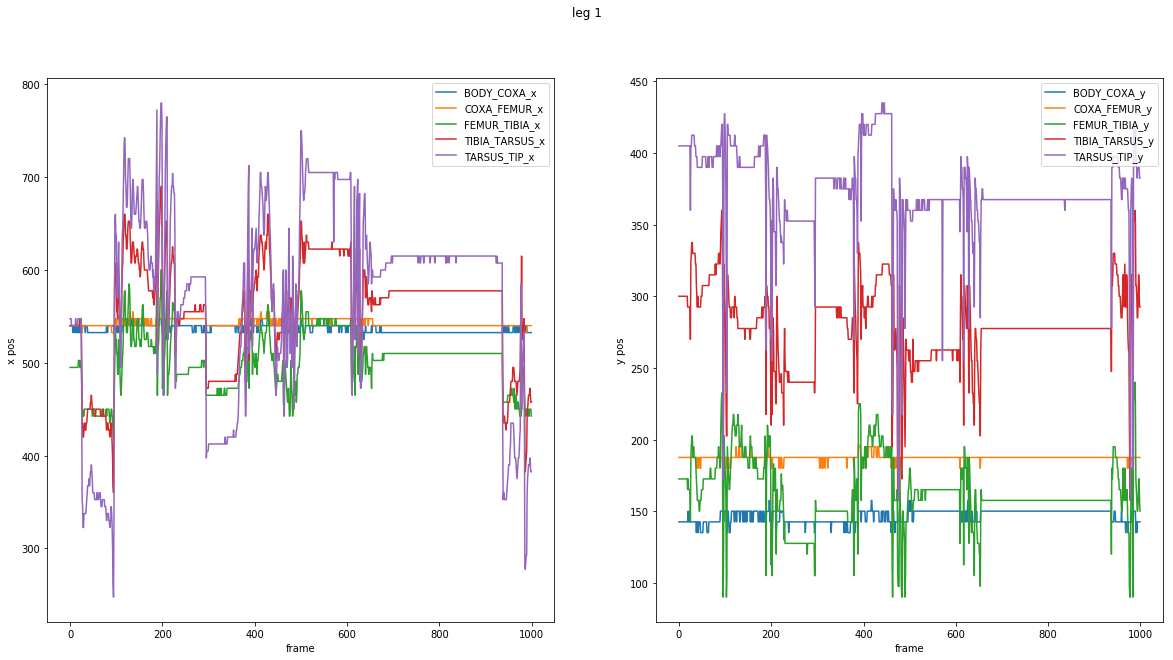

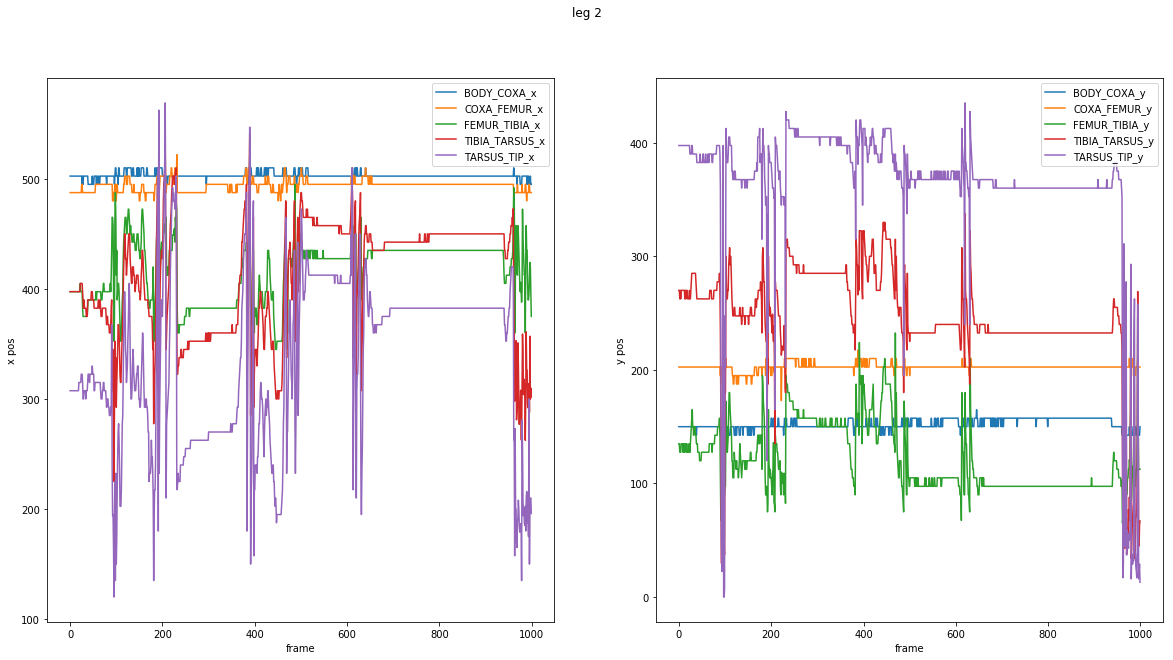

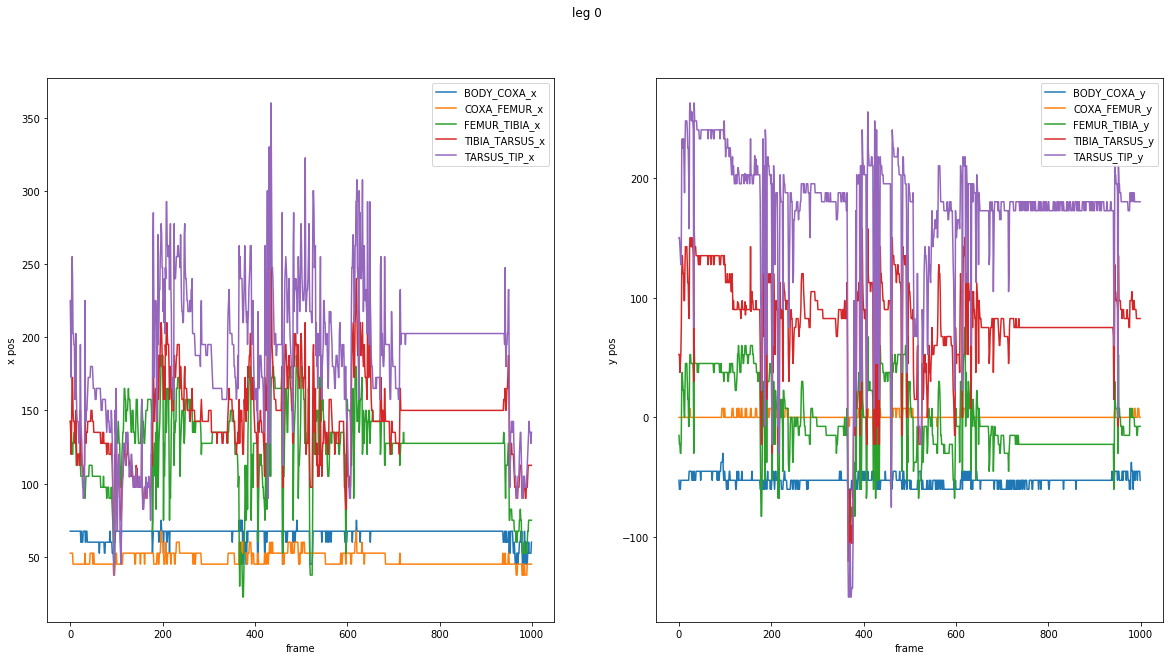

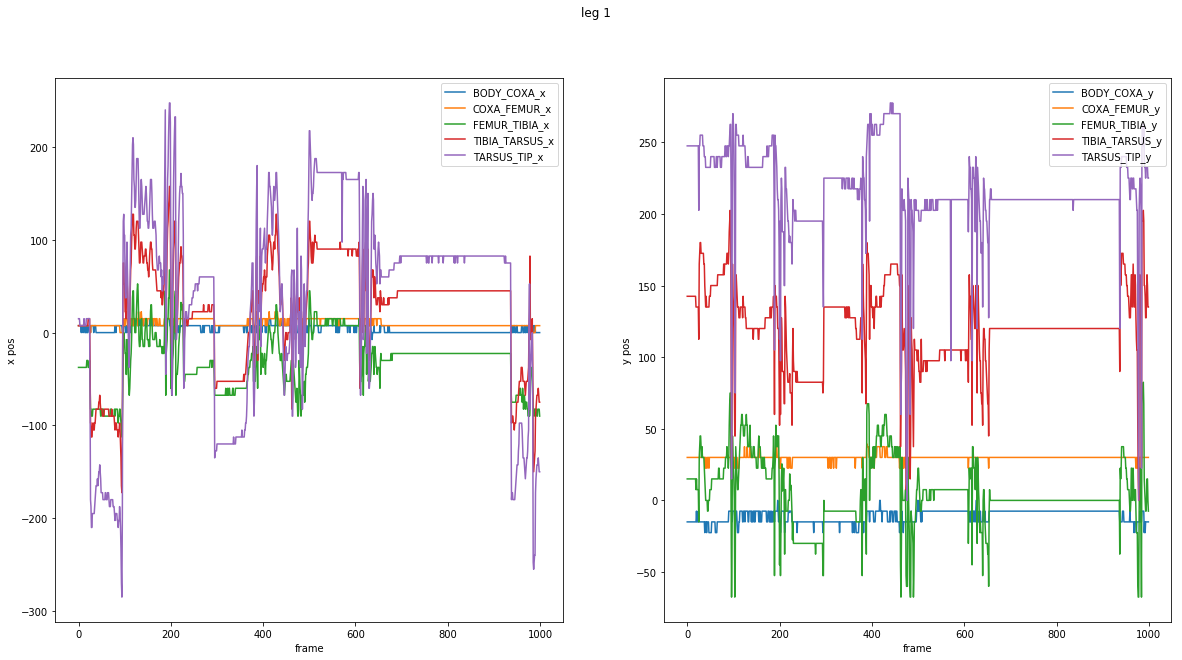

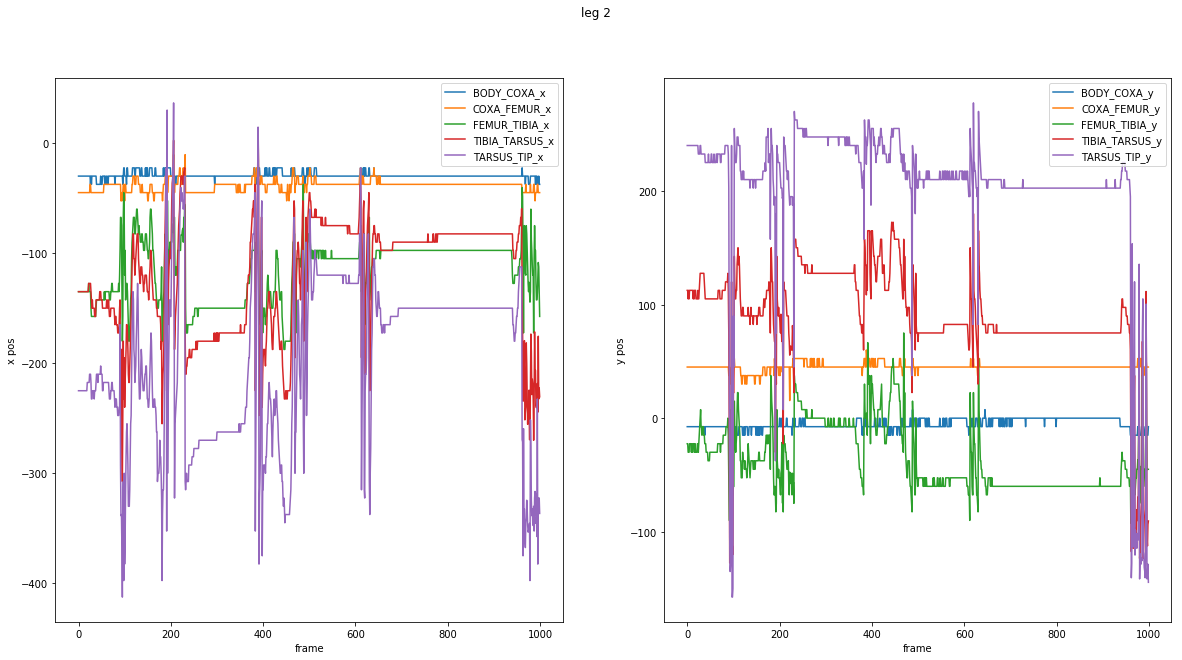

In [7]:
# -*- coding: utf-8 -*-
# <nbformat>4</nbformat>

# <markdowncell>

# # Imports

# <codecell>


# <codecell>

import sys
sys.path.append('/home/samuel/')

from drosophpose.GUI import skeleton


LEGS = [0, 1, 2, 5, 6, 7]
LEGS = [0, 1, 2] #, 5, 6, 7] # since we do not care about the other side
CAMERA_OF_INTEREST = 1
NB_OF_AXIS = 2
NB_TRACKED_POINTS = 5 # per leg, igoring the rest for now
NB_CAMERAS = 7
NB_RECORDED_DIMESIONS = 2

FRAMES_PER_SECOND = 100
NYQUIST_FREQUENCY_OF_MEASUREMENTS = FRAMES_PER_SECOND / 2

# <codecell>

POSE_DATA_PATH = "/ramdya-nas/SVB/181220_Rpr_R57C10_GC6s_tdTom/001_coronal/behData/images_renamed/pose_result__mnt_NAS_SVB_181220_Rpr_R57C10_GC6s_tdTom_001_coronal_behData_images_renamed.pkl"

# <markdowncell>

# # Loading data

# <markdowncell>

# ## loading 

# <codecell>

def load_data(path=POSE_DATA_PATH):
    with open(POSE_DATA_PATH, 'rb') as f:
        pose_data_raw = pickle.load(f)
        return pose_data_raw['points2d']

# <markdowncell>

# ## simple checks

# <codecell>

def _check_shape_(joint_positions):
    """ should be (7, <nb frames>, 38, 2)
    7 for the images, some should be 0 because it didn't record the images for these points
    1000 for the nb of frames
    38 for the features (some for the legs ...) check skeleton.py in semigh's code
    2 for the pose dimensions
    """
    s = joint_positions.shape
    
    if s[0] != NB_CAMERAS or s[2] != len(skeleton.tracked_points) or s[3] != NB_RECORDED_DIMESIONS:
        raise ValueError(f"shape of pose data is wrong, it's {joint_positions.shape}")
        
    return joint_positions 

def _crude_value_check_(joint_positions):
    if np.sum(joint_positions == 0) == np.product(joint_positions.shape):
        raise ValueError('not every value should be zero')
        
    return joint_positions

def _simple_checks_(data):
    return reduce(lambda acc, el: el(acc), [_check_shape_, _crude_value_check_], data)

# <markdowncell>

# ## extracting data of interest

# <codecell>

def _get_camera_of_interest_(joint_positions, camera_idx=CAMERA_OF_INTEREST):
    return joint_positions[CAMERA_OF_INTEREST]

def _get_visible_legs_(joint_positions, camera_idx=CAMERA_OF_INTEREST):
    idx_visible_joints = [skeleton.camera_see_joint(CAMERA_OF_INTEREST, j) for j in range(len(skeleton.tracked_points))]
    return joint_positions[:, idx_visible_joints, :]

# <codecell>

def get_data(path=POSE_DATA_PATH):
    return reduce(lambda acc, el: el(acc), 
                  [_get_camera_of_interest_, _get_visible_legs_],
                  _simple_checks_(load_data(path)))


# <markdowncell>

# ## adding third dimension

# <codecell>

def add_third_dimension(joint_positions):
    # just add a z-axis
    # assumes that the positional data is in the last axis
    paddings = [[0, 0] for i in joint_positions.shape]
    paddings[-1][1] = 1

    return np.pad(joint_positions, paddings, mode='constant', constant_values=0)

# <markdowncell>

# ## executing

# <codecell>

joint_positions = add_third_dimension(get_data())

NB_FRAMES = joint_positions.shape[1]

# <codecell>

for leg in LEGS:
    print("{0:.3}% of the data for leg {1} is 0".format((joint_positions[:, leg:leg+5, :2] == 0).mean(), leg))

# <markdowncell>

# # Checking data

# <codecell>

def _get_feature_name_(tracking_id):
    return str(skeleton.tracked_points[tracking_id])[len('Tracked.'):]

def _get_feature_id_(leg_id, tracking_point_id):
    if leg_id < 3:
        return leg_id * 5 + tracking_point_id
    else:
        return (leg_id - 5) * 5 + tracking_point_id + 19

# <codecell>

def ploting_frames(joint_positions):
    for leg in LEGS:
        fig, axs = plt.subplots(1, NB_OF_AXIS, sharex=True, figsize=(20, 10))
        for tracked_point in range(NB_TRACKED_POINTS):
            for axis in range(NB_OF_AXIS):
                cur_ax = axs[axis]
                cur_ax.plot(joint_positions[:, _get_feature_id_(leg, tracked_point),  axis], label = f"{_get_feature_name_(tracked_point)}_{('x' if axis == 0 else 'y')}")
                if axis == 0:
                    cur_ax.set_ylabel('x pos')
                else:
                    cur_ax.set_ylabel('y pos')
                cur_ax.legend(loc='upper right')
                cur_ax.set_xlabel('frame')

        #plt.xlabel('frame')
        #plt.legend(loc='lower right')
        plt.suptitle('leg ' + str(leg))

# <codecell>

ploting_frames(joint_positions)

# <markdowncell>

# ## Normalization

# <codecell>

def normalize(joint_positions, using_median=True, to_probability_distr=False):
    # alternatives could be to use only the median of the first joint -> data is then fixed to top (is that differnt to now?)
    if using_median:
        return joint_positions - np.median(joint_positions.reshape(-1, 3), axis=0)
    elif to_probability_distr:
        return
    else:
        raise NotImplementedError

# <codecell>

def normalize_ts(time_series, ax=0):
    # for shape (frame,feat)
    eps = 0.0001
    print("shapes:", np.shape(np.transpose(time_series)), np.shape(np.mean(np.transpose(time_series), axis=ax)))
#     n_time_series = (np.transpose(time_series) - np.mean(np.transpose(time_series), axis=ax))/(np.std(np.transpose(time_series), axis=ax) + eps)
    norm = np.sum(np.transpose(time_series), axis=ax); norm = np.transpose(norm) #shape = 1,frames
    n_time_series = np.transpose(time_series) / np.sum(np.transpose(time_series), axis=ax)
    n_time_series = np.transpose(n_time_series)
#     n_time_series = np.zeros(shape=np.shape(time_series))
#     for i in range(np.shape(time_series)[1]):
#         n_time_series[:,i] = (time_series[:,i] - np.mean(time_series[:,i])) / (np.std(time_series[:,i]) + eps)
    return n_time_series, norm


def normalize_pose(points3d, median3d=False):
    # normalize experiment
    if median3d:
        points3d -= np.median(points3d.reshape(-1, 3), axis=0)
    else:
        for i in range(np.shape(points3d)[1]): #frames
            for j in range(np.shape(points3d)[2]): #xyz
                points3d[:,i,j] = normalize_ts(points3d[:,i,j]) 
    return points3d

# <codecell>

joint_positions = normalize(joint_positions)

# <codecell>

ploting_frames(joint_positions)

In [8]:
joint_positions.shape

(1000, 19, 3)

In [9]:
# tensorflow data layout
# (x, y, channels)

# option 1
resh = joint_positions.reshape(-1, 19, 3, 1)

# option 2
#resh = joint_positions.reshape(-1, 19, 1, 3)

# option 3, flat
resh = joint_positions.reshape(-1, 1, 1, 3 * 19)

In [10]:
reload(somvae_model)

<module 'som_vae.somvae_model' from '/home/samuel/SOM-VAE/som_vae/somvae_model.py'>

In [11]:
## mnist
#mnist = input_data.read_data_sets(f"../data/{ex_config()['data_set']}")
#nb_of_data_points = 45000
#data_train = np.reshape(mnist.train.images, [-1,28,28,1])
#labels_train = mnist.train.labels

## fly data
nb_of_data_points = 800 
data_train = resh
# just generating some labels, no clue what they are for except validation?
labels_train = np.array(list(range(resh.shape[0])))

data_val = data_train[nb_of_data_points:]
labels_val = labels_train[nb_of_data_points:]
data_train = data_train[:nb_of_data_points]
labels_train = data_train[:nb_of_data_points]


In [12]:
## helper code

@ex.capture
def get_data_generator(time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if time_series:
                for i, image in enumerate(images):
                    start_image = image
                    end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator


@ex.capture
def train_model(model, x, lr_val, num_epochs, patience, batch_size, logdir,
        modelpath, learning_rate, interactive, generator):
    """Trains the SOM-VAE model.
    
    Args:
        model (SOM-VAE): SOM-VAE model to train.
        x (tf.Tensor): Input tensor or placeholder.
        lr_val (tf.Tensor): Placeholder for the learning rate value.
        num_epochs (int): Number of epochs to train.
        patience (int): Patience parameter for the early stopping.
        batch_size (int): Batch size for the training generator.
        logdir (path): Directory for saving the logs.
        modelpath (path): Path for saving the model checkpoints.
        learning_rate (float): Learning rate for the optimization.
        interactive (bool): Indicator if we want to have an interactive
            progress bar for training.
        generator (generator): Generator for the data batches.
    """
    train_gen = generator("train", batch_size)
    val_gen = generator("val", batch_size)

    num_batches = len(data_train)//batch_size

    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    summaries = tf.summary.merge_all()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        patience_count = 0
        test_losses = []
        with LogFileWriter(ex):
            train_writer = tf.summary.FileWriter(logdir+"/train", sess.graph)
            test_writer = tf.summary.FileWriter(logdir+"/test", sess.graph)
        print("Training...")
        train_step_SOMVAE, train_step_prob = model.optimize
        try:
            if interactive:
                pbar = tqdm(total=num_epochs*(num_batches)) 
            for epoch in range(num_epochs):
                batch_val = next(val_gen)
                test_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_val})
                test_losses.append(test_loss)
                test_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                if test_losses[-1] == min(test_losses):
                    saver.save(sess, modelpath, global_step=epoch)
                    patience_count = 0
                else:
                    patience_count += 1
                if patience_count >= patience:
                    break
                for i in range(num_batches):
                    batch_data = next(train_gen)
                    if i%100 == 0:
                        train_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_data})
                        train_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                    train_step_SOMVAE.run(feed_dict={x: batch_data, lr_val:learning_rate})
                    train_step_prob.run(feed_dict={x: batch_data, lr_val:learning_rate*100})
                    if interactive:
                        pbar.set_postfix(epoch=epoch, train_loss=train_loss, test_loss=test_loss, refresh=False)
                        pbar.update(1)

        except KeyboardInterrupt:
            pass
        finally:
            saver.save(sess, modelpath)
            if interactive:
                pbar.close()


@ex.capture
def evaluate_model(model, x, modelpath, batch_size):
    """Evaluates the performance of the trained model in terms of normalized
    mutual information, purity and mean squared error.
    
    Args:
        model (SOM-VAE): Trained SOM-VAE model to evaluate.
        x (tf.Tensor): Input tensor or placeholder.
        modelpath (path): Path from which to restore the model.
        batch_size (int): Batch size for the evaluation.
        
    Returns:
        dict: Dictionary of evaluation results (NMI, Purity, MSE).
    """
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)

    num_batches = len(data_val)//batch_size
    cfg = tf.ConfigProto()
    cfg.gpu_options.allow_growth = True

    with tf.Session(config=cfg) as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modelpath)

        test_k_all = []
        test_rec_all = []
        test_mse_all = []
        print("Evaluation...")
        for i in range(num_batches):
            batch_data = data_val[i*batch_size:(i+1)*batch_size]
            test_k_all.extend(sess.run(model.k, feed_dict={x: batch_data}))
            test_rec = sess.run(model.reconstruction_q, feed_dict={x: batch_data})
            test_rec_all.extend(test_rec)
            test_mse_all.append(mean_squared_error(test_rec.flatten(), batch_data.flatten()))

        test_nmi = compute_NMI(test_k_all, labels_val[:len(test_k_all)])
        test_purity = compute_purity(test_k_all, labels_val[:len(test_k_all)])
        test_mse = np.mean(test_mse_all)

    results = {}
    results["NMI"] = test_nmi
    results["Purity"] = test_purity
    results["MSE"] = test_mse
#    results["optimization_target"] = 1 - test_nmi

    return results
 


In [13]:
resh.shape

(1000, 1, 1, 57)

In [14]:
reload(somvae_model)
@ex.main
def main(latent_dim, som_dim, learning_rate, decay_factor, alpha, beta, gamma, tau, modelpath, save_model, mnist):
    """Main method to build a model, train it and evaluate it.
    
    Args:
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the SOM.
        learning_rate (float): Learning rate for the training.
        decay_factor (float): Factor for the learning rate decay.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        modelpath (path): Path for the model checkpoints.
        save_model (bool): Indicates if the model should be saved after training and evaluation.
        
    Returns:
        dict: Results of the evaluation (NMI, Purity, MSE).
    """
    # Dimensions for MNIST-like data
    #input_length = 28
    #input_channels = 28
    #x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    input_length = 1
    input_channels = 19 * 3
    x = tf.placeholder(tf.float32, shape=[None, 1, 1, input_channels])
    #x = tf.placeholder(tf.float32, shape=[None, input_length, input_channels, 1])
    #x = tf.placeholder(tf.float32, shape=[None, input_length, 1, input_channels])

    data_generator = get_data_generator()

    lr_val = tf.placeholder_with_default(learning_rate, [])

    model = somvae_model.SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
            input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
            tau=tau, mnist=mnist)

    train_model(model, x, lr_val, generator=data_generator)

    result = evaluate_model(model, x)

    if not save_model:
        shutil.rmtree(os.path.dirname(modelpath))

    return result

In [16]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

tf.reset_default_graph()

res = ex.run(config_updates={'mnist': False, 'num_epochs': 2, 'time_series': False})

INFO - how - Running command 'main'
INFO - how - Started run with ID "104"


input channels (init): 57
Instructions for updating:
Colocations handled automatically by placer.


WARNING - tensorflow - From /home/samuel/.local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


latent dims 64, is mnist False
shape of h1 (?, 1, 1, 256)
shape of h2 (?, 1, 1, 128)
dims of ze (?, 1, 1, 64)
shape of z_e (?, 1, 1, 64)
shape of embeddings (8, 8, 64)
indices (z_q): Tensor("z_q/stack:0", shape=(?, 2), dtype=int64)
shape of z_q (recon q): (?, 64)
shape of h3 (recon q): (?, 128)
input channels (recon q): 57
x_hat shape (recon q): (?, 1, 1, 57)
shapes for input (?, 1, 1, 57), recon q (?, 1, 1, 57), recon e (?, 1, 1, 57)
Instructions for updating:
Use tf.cast instead.


WARNING - tensorflow - From /home/samuel/.local/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:667: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


WARNING - tensorflow - From /home/samuel/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
  0%|          | 0/50 [00:00<?, ?it/s]

Training...


100%|██████████| 50/50 [00:01<00:00, 35.48it/s, epoch=1, test_loss=2.02e+04, train_loss=2.21e+04]


Instructions for updating:
Use standard file APIs to check for files with this prefix.


WARNING - tensorflow - From /home/samuel/.local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./models/how_64_8-8_2019-03-23_dd6e2/how_64_8-8_2019-03-23_dd6e2.ckpt


INFO - tensorflow - Restoring parameters from ./models/how_64_8-8_2019-03-23_dd6e2/how_64_8-8_2019-03-23_dd6e2.ckpt
INFO - how - Result: {'NMI': 0.3379880126194748, 'Purity': 0.052083333333333336, 'MSE': 10015.125193243432}
INFO - how - Completed after 0:00:04


Evaluation...


In [19]:
res.config['modelpath']

'./models/how_64_8-8_2019-03-23_dd6e2/how_64_8-8_2019-03-23_dd6e2.ckpt'

In [22]:
ls models/

fly_tryouts_64_8-8_2019-03-21_0eee3/  replicating_64_8-8_2019-03-20_1bb50/
fly_tryouts_64_8-8_2019-03-21_fa936/  replicating_64_8-8_2019-03-20_20d34/
how_64_8-8_2019-03-21_0c90a/          replicating_64_8-8_2019-03-20_31fe9/
how_64_8-8_2019-03-21_1313e/          replicating_64_8-8_2019-03-20_74b8f/
how_64_8-8_2019-03-21_17642/          replicating_64_8-8_2019-03-20_7d73b/
how_64_8-8_2019-03-21_249b8/          replicating_64_8-8_2019-03-20_acd8b/
how_64_8-8_2019-03-21_46bcf/          replicating_64_8-8_2019-03-20_af24e/
how_64_8-8_2019-03-21_54146/          replicating_64_8-8_2019-03-20_bc282/
how_64_8-8_2019-03-21_adc66/          replicating_64_8-8_2019-03-20_eff68/
how_64_8-8_2019-03-21_bbb30/          replicating_64_8-8_2019-03-21_33440/
how_64_8-8_2019-03-21_d1e08/          replicating_64_8-8_2019-03-21_7d4ff/
hyperopt_64_8-8_2019-03-15_b95bd/     replicating_64_8-8_2019-03-21_7d831/
replicating_64_8-8_2019-03-20_0ca7c/  replicating_64_8-8_2019-03-21_a0ed8/
replicating_64_8-8_2019-0

In [23]:
res.config

{'__doc__': "Sacred configuration for the experiment.\n\nParams:\n    num_epochs (int): Number of training epochs.\n    patience (int): Patience for the early stopping.\n    batch_size (int): Batch size for the training.\n    latent_dim (int): Dimensionality of the SOM-VAE's latent space.\n    som_dim (list): Dimensionality of the self-organizing map.\n    learning_rate (float): Learning rate for the optimization.\n    alpha (float): Weight for the commitment loss.\n    beta (float): Weight for the SOM loss.\n    gamma (float): Weight for the transition probability loss.\n    tau (float): Weight for the smoothness loss.\n    decay_factor (float): Factor for the learning rate decay.\n    name (string): Name of the experiment.\n    ex_name (string): Unique name of this particular run.\n    logdir (path): Directory for the experiment logs.\n    modelpath (path): Path for the model checkpoints.\n    interactive (bool): Indicator if there should be an interactive progress bar for the traini

In [33]:
reload(somvae_model)

tf.reset_default_graph()
input_length = 1
input_channels = 19 * 3
x = tf.placeholder(tf.float32, shape=[None, 1, 1, input_channels])
#x = tf.placeholder(tf.float32, shape=[None, input_length, input_channels, 1])
#x = tf.placeholder(tf.float32, shape=[None, input_length, 1, input_channels])

data_generator = get_data_generator()
learning_rate = 0.0005
lr_val = tf.placeholder_with_default(learning_rate, [])

model = somvae_model.SOMVAE(inputs=x, input_length=input_length, input_channels=input_channels, mnist=False)
train_model(model, x, lr_val, generator=data_generator)

result = evaluate_model(model, x)

input channels (init): 57
latent dims 64, is mnist False
shape of h1 (?, 1, 1, 256)
shape of h2 (?, 1, 1, 128)
dims of ze (?, 1, 1, 64)
shape of z_e (?, 1, 1, 64)
shape of embeddings (8, 8, 64)
indices (z_q): Tensor("z_q/stack:0", shape=(?, 2), dtype=int64)
shape of z_q (recon q): (?, 64)
shape of h3 (recon q): (?, 128)
input channels (recon q): 57
x_hat shape (recon q): (?, 1, 1, 57)
shapes for input (?, 1, 1, 57), recon q (?, 1, 1, 57), recon e (?, 1, 1, 57)


  0%|          | 0/50 [00:00<?, ?it/s]

Training...


100%|██████████| 50/50 [00:01<00:00, 43.15it/s, epoch=1, test_loss=2.06e+04, train_loss=2.21e+04]


INFO:tensorflow:Restoring parameters from ./models/how_64_8-8_2019-03-23_dd6e2/how_64_8-8_2019-03-23_dd6e2.ckpt


INFO - tensorflow - Restoring parameters from ./models/how_64_8-8_2019-03-23_dd6e2/how_64_8-8_2019-03-23_dd6e2.ckpt


Evaluation...


In [37]:
model.z_e.eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [17]:
res.result

{'NMI': 0.3379880126194748,
 'Purity': 0.052083333333333336,
 'MSE': 10015.125193243432}

In [28]:
model

NameError: name 'model' is not defined